In [14]:
import os

# 数据路径配置
train_data_path = "../data/riddles/zimi/zimi_train_data.csv"
label_to_index_path = "../data/results/label_to_index.json"
index_to_label_path = "../data/results/index_to_label.json"
model_save_path = "../models/structure_classifier/riddle_classifier.pth"
# embedding_model_path = "BAAI/bge-small-zh-v1.5"  # 修改为你的模型路径
embedding_model_path = "../../model/bge-small-zh-v1.5"  # 修改为你的模型路径

# 超参数配置
max_length = 50
batch_size = 16
learning_rate = 2e-6
num_epochs = 100
test_size = 0.2
oversample_size = 0.5

# 检查并创建保存模型的目录
model_dir = os.path.dirname(model_save_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [15]:
import pandas as pd
import ast
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import random
from collections import Counter
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json


In [16]:
# 安全地将字符串转换为原始格式（列表或字典），对于无效格式返回原始值。
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if not pd.isna(val) else val
    except (ValueError, SyntaxError):
        return val

# 读取数据
zimi_df = pd.read_csv(train_data_path).dropna()
zimi_df['拆字'] = zimi_df['拆字'].apply(safe_literal_eval)
zimi_df['pronunciation_details'] = zimi_df['pronunciation_details'].apply(safe_literal_eval)
zimi_df.head(5)


,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
0,劲,7,jìn,力,1,H0,[圣 力],左右结构,左右结构,劲,926.0,jìn,"{'pinyin': 'jìn', 'explanations': [{'content':...",[左右],圣力,[左右]圣力,左侧执圣，右侧持力
1,拔,8,bá,扌,1,H2,"[手 犮, 扌 犮, 才 犮]",左右结构,左窄右宽,拔,959.0,bá,"{'pinyin': 'bá', 'explanations': [{'content': ...",[左右],手犮,[左右]手犮,弓的左侧，手待发之势；弓的右侧，犮射出之力
2,酒,10,jiǔ,酉,1,H0,"[水 酉, 氵 酉]",左右结构,左右结构,酒,2069.0,jiǔ,"{'pinyin': 'jiǔ', 'explanations': [{'content':...",[左右],水酉,[左右]水酉,左边是水，右边是酉
3,蟋,17,xī,虫,2,H2,[虫 悉],左右结构,左窄右宽,蟋,3411.0,xī,"{'pinyin': 'xī', 'explanations': [{'content': ...",[左右],虫悉,[左右]虫悉,左侧执虫，右侧持悉
4,栈,9,zhàn,木,2,H2,[木 戋],左右结构,左窄右宽,栈,1425.0,zhàn,"{'pinyin': 'zhàn', 'explanations': [{'content'...",[左右],木戋,[左右]木戋,门的左扇，木装饰之美；门的右扇，戋简约之雅


In [17]:
zimi_df[zimi_df["结构谜底"]=="[上中下]"]

,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
299,鼻,14,bí,鼻,1,E0,[自 田 廾],上中下结构,上中下结构,鼻,3128.0,bí,"{'pinyin': 'bí', 'explanations': [{'content': ...",[上中下],自田廾,[上中下]自田廾,上段自轻盈如风，中段田稳如山，下段廾厚重如地
790,帚,8,zhǒu,巾,2,E0,[彐 冖 巾],上中下结构,上中下结构,帚,1306.0,zhǒu,"{'pinyin': 'zhǒu', 'explanations': [{'content'...",[上中下],彐冖巾,[上中下]彐冖巾,上层彐飘逸，中层冖凝练，下层巾沉着
1209,壹,12,yī,士,2,E0,[士 冖 豆],上中下结构,上中下结构,壹,2537.0,yī,"{'pinyin': 'yī', 'explanations': [{'content': ...",[上中下],士冖豆,[上中下]士冖豆,顶上士，中段冖，底下豆
1353,曼,11,màn,曰,2,E0,[曰 目 又],上中下结构,上中下结构,曼,2268.0,màn,"{'pinyin': 'màn', 'explanations': [{'content':...",[上中下],曰目又,[上中下]曰目又,上头曰点缀，中间目连接，下端又支撑
1728,害,10,hài,宀,1,E0,[宀 丰 口],上中下结构,上中下结构,害,2097.0,hài,"{'pinyin': 'hài', 'explanations': [{'content':...",[上中下],宀丰口,[上中下]宀丰口,上宀如同天空的日出，中丰如同午间的烈阳，下口如同黄昏的晚霞


In [18]:
zimi_df[zimi_df["结构谜底"]=="[全包围]"]

,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
67,团,6,tuán,囗,0,Q0,[囗 才],全包围结构,全包围,团,425.0,tuán,"{'pinyin': 'tuán', 'explanations': [{'content'...",[全包围],囗才,[全包围]囗才,外圈囗围绕，内里才守护
184,园,7,yuán,囗,1,Q0,[囗 元],全包围结构,全包围,园,726.0,yuán,"{'pinyin': 'yuán', 'explanations': [{'content'...",[全包围],囗元,[全包围]囗元,外部囗包围，内部元藏匿
270,回,6,huí,囗,0,Q0,[囗 口],全包围结构,全包围,回,438.0,huí,"{'pinyin': 'huí', 'explanations': [{'content':...",[全包围],囗口,[全包围]囗口,外围囗如盾，中心口如心
671,囚,5,qiú,囗,2,Q0,[囗 人],全包围结构,全包围,囚,261.0,qiú,"{'pinyin': 'qiú', 'explanations': [{'content':...",[全包围],囗人,[全包围]囗人,外囗庇护，中人藏匿
834,圈,11,juān,囗,1,Q0,[囗 卷],全包围结构,全包围,圈,2302.0,juān,"{'pinyin': 'juān', 'explanations': [{'content'...",[全包围],囗卷,[全包围]囗卷,外围囗环绕，中心卷静谧
1087,囤,7,dùn,囗,2,Q0,[囗 屯],全包围结构,全包围,囤,750.0,dùn,"{'pinyin': 'dùn', 'explanations': [{'content':...",[全包围],囗屯,[全包围]囗屯,外壳囗保护，内核屯精华
1110,圆,10,yuán,囗,0,Q0,[囗 员],全包围结构,全包围,圆,1922.0,yuán,"{'pinyin': 'yuán', 'explanations': [{'content'...",[全包围],囗员,[全包围]囗员,外围囗如盾，中心员如心
1176,四,5,sì,囗,0,Q0,[囗 儿],全包围结构,全包围,四,262.0,sì,"{'pinyin': 'sì', 'explanations': [{'content': ...",[全包围],囗儿,[全包围]囗儿,外围囗环绕，中心儿静谧
1308,圈,11,juàn,囗,1,Q0,[囗 卷],全包围结构,全包围,圈,2302.0,juàn,"{'pinyin': 'juàn', 'explanations': [{'content'...",[全包围],囗卷,[全包围]囗卷,外围囗环绕，中心卷静谧
1431,图,8,tú,囗,0,Q0,[囗 冬],全包围结构,全包围,图,1119.0,tú,"{'pinyin': 'tú', 'explanations': [{'content': ...",[全包围],囗冬,[全包围]囗冬,外围囗环绕，中心冬静谧


In [19]:
data = zimi_df.copy()
riddles = data['字谜'].tolist()
answers = data['结构谜底'].tolist()

# 创建标签映射
unique_labels = list(set(answers))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 保存标签映射
with open(label_to_index_path, 'w', encoding='utf-8') as f:
    json.dump(label_to_index, f, ensure_ascii=False, indent=4)

with open(index_to_label_path, 'w', encoding='utf-8') as f:
    json.dump(index_to_label, f, ensure_ascii=False, indent=4)


In [20]:
class RiddleStructureDataset(Dataset):
    def __init__(self, riddles, answers, label_to_index):
        self.riddles = riddles
        self.answers = answers
        self.label_to_index = label_to_index

        # 统计各类别样本数
        self.class_counts = Counter(answers)
        self.max_count = max(self.class_counts.values())

        # 过采样少数类
        self.oversample()

    def oversample(self):
        new_riddles = []
        new_answers = []
        target_count = int(self.max_count * oversample_size)  # 目标样本数，最多到最大类的一半

        for answer, count in self.class_counts.items():
            indices = [i for i, ans in enumerate(self.answers) if ans == answer]
            sample_count = min(target_count, self.max_count - count)

            if sample_count > 0:
                sampled_indices = random.choices(indices, k=sample_count)
                new_riddles.extend([self.riddles[i] for i in sampled_indices])
                new_answers.extend([self.answers[i] for i in sampled_indices])

        self.riddles.extend(new_riddles)
        self.answers.extend(new_answers)

    def __len__(self):
        return len(self.riddles)

    def __getitem__(self, idx):
        riddle = self.riddles[idx]
        answer = self.answers[idx]
        label_index = self.label_to_index[answer]

        return riddle, torch.tensor(label_index, dtype=torch.long)

# 自定义 collate 函数
def structure_collate_fn(batch):
    riddles = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch], dim=0)
    return riddles, labels


In [21]:
# 数据集分割
riddles_train, riddles_val, answers_train, answers_val = train_test_split(riddles, answers, test_size=test_size, random_state=42)

# 创建数据加载器
train_dataset = RiddleStructureDataset(riddles_train, answers_train, label_to_index)
val_dataset = RiddleStructureDataset(riddles_val, answers_val, label_to_index)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=structure_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=structure_collate_fn)


In [22]:
# 定义分类器
class RiddleStructureClassifier(nn.Module):
    def __init__(self, embedding_model, num_labels):
        super(RiddleStructureClassifier, self).__init__()
        self.embedding_model = embedding_model
        self.dropout = nn.Dropout(0.3)
        self.classifier1 = nn.Linear(embedding_model.get_sentence_embedding_dimension(), 768)
        self.classifier2 = nn.Linear(768, num_labels)

    def forward(self, input_sentences):
        embeddings = self.embedding_model.encode(input_sentences, convert_to_tensor=True)
        x_1 = self.dropout(embeddings)
        x_2 = F.relu(self.classifier1(x_1))
        logits = self.classifier2(x_2)
        return logits
    
    def classify(self, riddles, index_to_label):
        with torch.no_grad():
            logits = self(riddles)
            _, predicted_indices = torch.max(logits, 1)
            predicted_labels = [index_to_label[idx.item()] for idx in predicted_indices]
            return predicted_labels

# 加载预训练模型
sentence_model = SentenceTransformer(embedding_model_path)
sentence_model.to('cuda')

# 创建分类器和优化器
num_labels = len(unique_labels)
classifier = RiddleStructureClassifier(sentence_model, num_labels).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

In [23]:
class RiddleStructureSolver:
    def __init__(self, model, classifier, train_loader, val_loader, criterion, optimizer, num_epochs=3, device='cuda'):
        self.model = model.to(device)
        self.classifier = classifier.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train(self):
        for epoch in range(self.num_epochs):
            self.classifier.train()
            total_loss = 0
            for riddles, labels in self.train_loader:
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.classifier(riddles)  # riddles是str类型，无需调用.to(self.device)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            self.train_losses.append(total_loss)
            print(f'Epoch {epoch+1}, Total loss: {total_loss}')
            val_loss, val_accuracy = self.evaluate(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

    def evaluate(self, loader):
        self.classifier.eval()
        total, correct = 0, 0
        total_loss = 0
        with torch.no_grad():
            for riddles, labels in loader:
                labels = labels.to(self.device)
                outputs = self.classifier(riddles)  # riddles是str类型，无需调用.to(self.device)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Loss: {total_loss}, Validation Accuracy: {accuracy}%')
        return total_loss, accuracy

    def save_model(self, path):
        torch.save(self.classifier.state_dict(), path)

    def load_model(self, path):
        self.classifier.load_state_dict(torch.load(path))

# 实例化 RiddleStructureSolver 并开始训练
solver = RiddleStructureSolver(
    model=sentence_model,
    classifier=classifier,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device='cuda'
)

solver.train()


Epoch 1, Total loss: 350.57904291152954
Validation Loss: 85.06466782093048, Validation Accuracy: 25.02951593860685%
Epoch 2, Total loss: 349.0119209289551
Validation Loss: 84.7312136888504, Validation Accuracy: 25.02951593860685%
Epoch 3, Total loss: 347.4635730981827
Validation Loss: 84.39555525779724, Validation Accuracy: 29.161747343565526%
Epoch 4, Total loss: 345.83086013793945
Validation Loss: 84.05761456489563, Validation Accuracy: 42.97520661157025%
Epoch 5, Total loss: 344.2203004360199
Validation Loss: 83.71010196208954, Validation Accuracy: 50.0590318772137%
Epoch 6, Total loss: 342.52126455307007
Validation Loss: 83.35490655899048, Validation Accuracy: 54.07319952774498%
Epoch 7, Total loss: 340.8003189563751
Validation Loss: 82.98587369918823, Validation Accuracy: 56.08028335301063%
Epoch 8, Total loss: 338.99291920661926
Validation Loss: 82.60348904132843, Validation Accuracy: 58.08736717827627%
Epoch 9, Total loss: 337.10846304893494
Validation Loss: 82.20785212516785, V

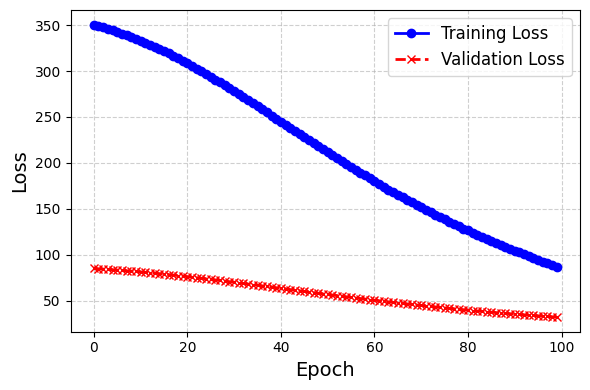

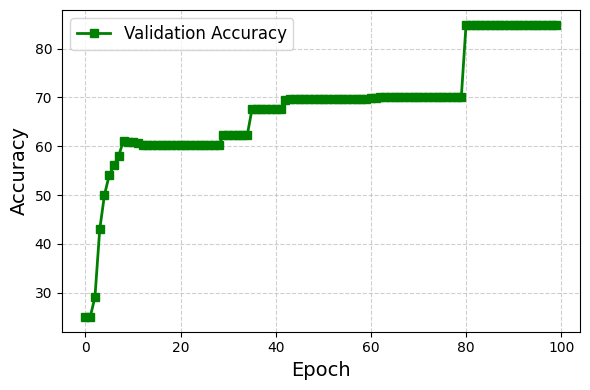

In [24]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2, marker='x')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_accuracies(val_accuracies):
    plt.figure(figsize=(6, 4))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', linewidth=2, marker='s')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_losses(solver.train_losses, solver.val_losses)
plot_accuracies(solver.val_accuracies)


In [25]:
solver.save_model(model_save_path)


In [26]:
# 加载预训练模型
sentence_model = SentenceTransformer(embedding_model_path).to('cuda')
classifier = RiddleStructureClassifier(sentence_model, num_labels).to('cuda')

# 加载模型
classifier.load_state_dict(torch.load(model_save_path))

# 测试分类器
riddles_to_classify = ['上层彐飘逸，中层冖凝练，下层巾沉着', '上有天，下有地']
predicted_labels = classifier.classify(riddles_to_classify, index_to_label)

for riddle, label in zip(riddles_to_classify, predicted_labels):
    print(f"Riddle: {riddle} --> Predicted Label: {label}")


Riddle: 上层彐飘逸，中层冖凝练，下层巾沉着 --> Predicted Label: [上中下]
Riddle: 上有天，下有地 --> Predicted Label: [上下]
